In [1]:
import csv
import time
import pickle
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameter optimization routines
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import Trials
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample

# persistence images routines
import PersistenceImages.persistence_images as pimgs

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os.path

from HyperoptUtils import *
from BoneData import *

## Persistence Images

In [ ]:
# -------------------
# Perform a Bayesian optimization search across persistence images
bone_df = get_bone_data_df()
dgm_df = bone_df[['dgm']]
target_df = bone_df['trabnum']
scorer = make_scorer(mean_squared_error)
max_evals = 1000
cv=6

# precompute the persistence image region over the full dataset
birth_range = (0, 0.5)
pers_range = (0, 0.61)
max_death = 0.7

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])

param_space = {'estimator_params': 
                {
                'method': pipeline_ridge,
                'kwargs':  {
                            'ridge__normalize':False,
                            'ridge__fit_intercept':True,
                            'ridge__alpha':hp.loguniform('alphas', -10, 6)
                            }
                },
                'dgm_vec_params':
                hp.choice('dgm_vec_params',
                [
                {
                'method': vec_dgm_by_per_images,
                'kwargs': {
                            'birth_range': birth_range,
                            'pers_range': pers_range,
                            'max_death': max_death,
                            'pixel_size': hp.uniform('pixel_size', 0.01, 0.1),
                            'weight_params': {'n': 1},
                            'kernel_params': {'sigma': 0.05},
                            'do_plot': False
                            }
                },
                {
                'method': vec_dgm_by_per,
                'kwargs': {
                             'start': hp.quniform('start', 0, 150, 1),
                             'num_pairs': 50, 
                             'per_only': hp.choice('per_only', [True, False])
                            }
                }
                ])
            }


# ---------------------------------
# create the objective function to minimize, passing in all fixed arguments
objective = lambda params: cv_objective(params,
                                        dgm_df=dgm_df,
                                        target_df=target_df, 
                                        scorer=scorer,
                                        cv=cv,
                                        verbose=True)

bayes_trials = Trials()

# run the hyperparamter optimization
best = fmin(fn=objective, 
            space=param_space, 
            algo=tpe.suggest, 
            max_evals=max_evals, 
            trials=bayes_trials)

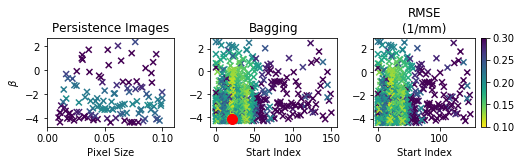

In [16]:
## Plot alpha vs pixel size

# Columns of loss, ridge alpha, pixel size, kernel width
YPI = []

# Columns of loss, ridge alpha, start, num_pairs, per_only
YBag = []

matfile = "Full_Search_FixKernel_NPairs.mat"
if not os.path.exists(matfile):
    for i, f in enumerate(bayes_trials):
        y = [f['result']['loss'], np.log10(f['result']['params']['estimator_params']['kwargs']['ridge__alpha'])]
        dparams = f['result']['params']['dgm_vec_params']['kwargs']
        if 'num_pairs' in dparams:
            y.append(dparams['start'])
            y.append(dparams['num_pairs'])
            y.append(int(dparams['per_only']))
            YBag.append(y)
        else:
            y.append(dparams['pixel_size'])
            y.append(dparams['kernel_params']['sigma'])
            YPI.append(y)
    YPI = np.array(YPI)
    YBag = np.array(YBag)
    sio.savemat(matfile, {"best":0.012, "YPI":YPI, "YBag":YBag})
else:
    res = sio.loadmat(matfile)
    YPI, YBag = res["YPI"], res["YBag"]

vmin = 0.1 #np.min(Y[:, 0])
vmax = 0.3 #p.max(Y[:, 0])

YPI[:, 0] = np.sqrt(YPI[:, 0])
YBag[:, 0] = np.sqrt(YBag[:, 0])

fac = 0.8
plt.figure(figsize=(fac*9, fac*3))
plt.subplot(131)
plt.scatter(YPI[:, 2], YPI[:, 1], c=YPI[:, 0], marker='x', cmap='viridis_r', vmin=vmin, vmax=vmax)
plt.xlim([0, 0.11])
plt.xlabel("Pixel Size (mm)")
plt.ylabel("$\\beta$")
plt.title("Persistence Images")
plt.subplot(132)
idx = np.argmin(YBag[:, 0])
plt.scatter(YBag[:, 2], YBag[:, 1], c=YBag[:, 0], marker='x', cmap='viridis_r', vmin=vmin, vmax=vmax)
plt.scatter(YBag[idx, 2], YBag[idx, 1], 100, c='r')
plt.xlabel("Start Index")
plt.title("Bagging")
plt.tight_layout()
plt.subplot(133)
idx = np.argmin(YBag[:, 0])
plt.scatter(YBag[idx, 2], YBag[idx, 1], c='r', marker='x')
plt.scatter(YBag[:, 2], YBag[:, 1], c=YBag[:, 0], marker='x', cmap='viridis_r', vmin=vmin, vmax=vmax)
plt.xlabel("Start Index")
plt.title("RMSE\n(1/mm)")
plt.tight_layout()
plt.colorbar()
plt.savefig("AlgoChoice_FixedParams.svg", bbox_inches='tight')